<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisites" data-toc-modified-id="Pre-requisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisites</a></span></li><li><span><a href="#Instructions" data-toc-modified-id="Instructions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Instructions</a></span></li><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Validate-and-Split-Exported-TFRecords" data-toc-modified-id="Validate-and-Split-Exported-TFRecords-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Validate and Split Exported TFRecords</a></span></li><li><span><a href="#Calculate-Mean-and-Std-Dev-for-Each-Band" data-toc-modified-id="Calculate-Mean-and-Std-Dev-for-Each-Band-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calculate Mean and Std-Dev for Each Band</a></span></li></ul></div>

## Pre-requisites

Go through the [`preprocessing/0_export_tfrecords.ipynb`](./0_export_tfrecords.ipynb) notebook.

Before running this notebook, you should have the following structure under the `data/` directory:

```
data/
    dhs_tfrecords_raw/
        angola_2011_00.tfrecord.gz
        ...
        zimbabwe_2015_XX.tfrecord.gz
    dhsnl_tfrecords_raw/
        angola_2010_00.tfrecord.gz
        ...
        zimbabwe_2016_XX.tfrecord.gz
    lsms_tfrecords_raw/
        ethiopia_2011_00.tfrecord.gz
        ...
        uganda_2013_XX.tfrecord.gz
```

## Instructions

This notebook processes the exported TFRecords as follows:
1. Verifies that the fields in the TFRecords match the original CSV files.
2. Splits each monolithic TFRecord file exported from Google Earth Engine into one file per record.

After running this notebook, you should have three new folders (`dhs_tfrecords`, `dhsnl_tfrecords`, and `lsms_tfrecords`) under `data/`:

```
data/
    dhs_tfrecords/
        angola_2011/
            00000.tfrecord.gz
            ...
            00229.tfrecord.gz
        ...
        zimbabwe_2015/
            00000.tfrecord.gz
            ...
            00399.tfrecord.gz
    dhsnl_tfrecords/
        angola_2010/
            00000.tfrecord.gz
            ...
            07734.tfrecord.gz
        zimbabwe_2016/
            00000.tfrecord.gz
            ...
            03584.tfrecord.gz
    lsms_tfrecords/
        ethiopia_2011/
            00000.tfrecord.gz
            ...
            00326.tfrecord.gz
        uganda_2013/
            00000.tfrecord.gz
            ...
            00164.tfrecord.gz
```

This notebook also calculates the mean and standard deviation of each band across each of the 3 datasets.

## Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2

# change directory to repo root, and verify
%cd '../'
!pwd

/home/saori/code/saoriyosano/poverty_mapper
/home/saori/code/saoriyosano/poverty_mapper


In [2]:
from __future__ import annotations

from collections.abc import Iterable
from glob import glob
from pprint import pprint
import os
from typing import Optional

import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm

from batchers import batcher, tfrecord_paths_utils
from preprocessing.helper import (
    analyze_tfrecord_batch,
    per_band_mean_std,
    print_analysis_results)

In [3]:
REQUIRED_BANDS = [
    'BLUE', 'GREEN', 'LAT', 'LON', 'NIGHTLIGHTS', 'NIR', 'RED',
    'SWIR1', 'SWIR2', 'TEMP1']

BANDS_ORDER = [
    'BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR',
    'DMSP', 'VIIRS']

DHS_EXPORT_FOLDER = 'dhs_raw_images' # changed
# DHSNL_EXPORT_FOLDER = 'data/dhsnl_tfrecords_raw'
# LSMS_EXPORT_FOLDER = 'data/lsms_tfrecords_raw'

DHS_PROCESSED_FOLDER = 'data/dhs_tfrecords'
# DHSNL_PROCESSED_FOLDER = 'data/dhsnl_tfrecords'
# LSMS_PROCESSED_FOLDER = 'data/lsms_tfrecords'

### Exploring the data ...

In [15]:
csv_path='data/dhs_clusters.csv'
df = pd.read_csv(csv_path, float_precision='high', index_col=False)
surveys = list(df.groupby(['country', 'year']).groups.keys())  # (country, year) tuples
csv_feats = df.loc[0, :].to_dict()
csv_feats

{'country': 'angola',
 'year': 2011,
 'lat': -12.350257,
 'lon': 13.534922,
 'wealthpooled': 2.5956175327301,
 'households': 36,
 'urban_rural': 1}

In [28]:
surveys[0:1]

[('angola', 2011)]

In [22]:
df

,country,year,lat,lon,wealthpooled,households,urban_rural
0,angola,2011,-12.350257,13.534922,2.595618,36,1
1,angola,2011,-12.360865,13.551494,2.209620,32,1
2,angola,2011,-12.613421,13.413085,0.906469,36,1
3,angola,2011,-12.581454,13.397711,1.105359,35,1
4,angola,2011,-12.578135,13.418748,1.879344,37,1
...,...,...,...,...,...,...,...
19664,zimbabwe,2015,-17.915288,31.156115,0.237659,24,1
19665,zimbabwe,2015,-18.379501,31.872287,0.492502,25,0
19666,zimbabwe,2015,-16.660612,29.850649,-0.088922,28,0
19667,zimbabwe,2015,-17.914251,30.956975,1.613829,25,1


In [37]:
first_record = "dhs_raw_images/dhs_tfrecords_raw_angola_2011_01.tfrecord.gz"
options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)

iterator = tf.io.tf_record_iterator(first_record, options=options)
i = 1
for record_str in iterator:
    print(f"======== image {i} ========")
    ex = tf.train.Example.FromString(record_str)
    feature_map = ex.features.feature
    for col, val in csv_feats.items():
        ft_type = feature_map[col].WhichOneof('kind')
        print(feature_map[col], feature_map[col].WhichOneof('kind'))
        print(feature_map[col].__getattribute__(ft_type).value[0])
#     print(feature_map['country'], feature_map['year'], feature_map['lat'], feature_map['lon'], 
#             feature_map['wealthpooled'], feature_map['households'], feature_map['urban_rural'])
    i += 1
    break


======== image 1 ========
bytes_list {
  value: "angola"
}
 bytes_list
b'angola'
float_list {
  value: 2011.0
}
 float_list
2011.0
float_list {
  value: -12.739749908447266
}
 float_list
-12.739749908447266
float_list {
  value: 15.662196159362793
}
 float_list
15.662196159362793
float_list {
  value: -0.367856502532959
}
 float_list
-0.367856502532959
float_list {
  value: 35.0
}
 float_list
35.0
float_list {
  value: 0.0
}
 float_list
0.0


In [59]:
i=0
for i in range(10):
    try:
        _ = glob(os.path.join(
            'dhs_raw_images/dhs_tfrecords_raw_' + 'angola_2011' + '*'
            ))
    except:
        print('end')

In [60]:
_

['dhs_raw_images/dhs_tfrecords_raw_angola_2011_01.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_03.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_04.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_02.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_00.tfrecord.gz']

In [62]:
sorted(_)

['dhs_raw_images/dhs_tfrecords_raw_angola_2011_00.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_01.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_02.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_03.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_04.tfrecord.gz']

In [63]:
_

['dhs_raw_images/dhs_tfrecords_raw_angola_2011_01.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_03.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_04.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_02.tfrecord.gz',
 'dhs_raw_images/dhs_tfrecords_raw_angola_2011_00.tfrecord.gz']

## Validate and Split Exported TFRecords

In [4]:
import pdb

In [65]:
def process_dataset(csv_path: str, input_dir: str, processed_dir: str) -> None:
    '''
    Args
    - csv_path: str, path to CSV of DHS or LSMS clusters
    - input_dir: str, path to TFRecords exported from Google Earth Engine
    - processed_dir: str, folder where to save processed TFRecords
    '''
    df = pd.read_csv(csv_path, float_precision='high', index_col=False)
    surveys = list(df.groupby(['country', 'year']).groups.keys())  # (country, year) tuples
    
    for country, year in surveys[0:1]:
        country_year = f'{country}_{year}'
        print('Processing:', country_year)
        tfrecord_paths = glob(os.path.join(input_dir, 'dhs_tfrecords_raw_' + country_year + '*'))
        tfrecord_paths = sorted(tfrecord_paths)
        # pdb.set_trace()
        out_dir = os.path.join(processed_dir, country_year)
        os.makedirs(out_dir, exist_ok=True)
        subset_df = df[(df['country'] == country) & (df['year'] == year)].reset_index(drop=True)

        options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)

        # cast float64 => float32 and str => bytes
        for col in df.columns:
            if df[col].dtype == np.float64:
                df[col] = df[col].astype(np.float32)
            elif df[col].dtype == object:  # pandas uses 'object' type for str
                df[col] = df[col].astype(bytes)

        i = 0
        # progbar = tqdm(total=len(df))
        # pdb.set_trace()
        for tfrecord_path in tfrecord_paths:
            iterator = tf.io.tf_record_iterator(tfrecord_path, options=options)
            for record_str in iterator:
                # parse into an actual Example message
                ex = tf.train.Example.FromString(record_str)
                feature_map = ex.features.feature
                # pdb.set_trace()

                # verify required bands exist
                for band in REQUIRED_BANDS:
                    assert band in feature_map, f'Band "{band}" not in record {i} of {tfrecord_path}'

                # compare feature map values against CSV values
                csv_feats = df.loc[i, :].to_dict()
                # pdb.set_trace()
                for col, val in csv_feats.items():
                    ft_type = feature_map[col].WhichOneof('kind')
                    ex_val = feature_map[col].__getattribute__(ft_type).value[0]
                    # pdb.set_trace()
                    assert val == ex_val, f'Expected {col}={val}, but found {ex_val} instead'

                # serialize to string and write to file
                out_path = os.path.join(out_dir, f'{i:05d}.tfrecord.gz')  # all surveys have < 1e6 clusters
                # pdb.set_trace()
                with tf.io.TFRecordWriter(out_path, options=options) as writer:
                    writer.write(ex.SerializeToString())

                i += 1
        # validate_and_split_tfrecords(
        #     tfrecord_paths=tfrecord_paths, out_dir=out_dir, df=subset_df)


# def validate_and_split_tfrecords(
#         tfrecord_paths: Iterable[str],
#         out_dir: str,
#         df: pd.DataFrame
#         ) -> None:
#     '''Validates and splits a list of exported TFRecord files (for a
#     given country-year survey) into individual TFrecords, one per cluster.

#     "Validating" a TFRecord comprises of 2 parts
#     1) verifying that it contains the required bands
#     2) verifying that its other features match the values from the dataset CSV

#     Args
#     - tfrecord_paths: list of str, paths to exported TFRecords files
#     - out_dir: str, path to dir to save processed individual TFRecords
#     - df: pd.DataFrame, index is sequential and starts at 0
#     '''
#     # Create an iterator over the TFRecords file. The iterator yields
#     # the binary representations of Example messages as strings.
#     options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)

#     # cast float64 => float32 and str => bytes
#     for col in df.columns:
#         if df[col].dtype == np.float64:
#             df[col] = df[col].astype(np.float32)
#         elif df[col].dtype == object:  # pandas uses 'object' type for str
#             df[col] = df[col].astype(bytes)

#     i = 0
#     # progbar = tqdm(total=len(df))
    
#     for tfrecord_path in tfrecord_paths:
#         iterator = tf.io.tf_record_iterator(tfrecord_path, options=options)
#         for record_str in iterator:
#             # parse into an actual Example message
#             ex = tf.train.Example.FromString(record_str)
#             feature_map = ex.features.feature

#             # verify required bands exist
#             for band in REQUIRED_BANDS:
#                 assert band in feature_map, f'Band "{band}" not in record {i} of {tfrecord_path}'

#             # compare feature map values against CSV values
#             csv_feats = df.loc[i, :].to_dict()
#             for col, val in csv_feats.items():
#                 ft_type = feature_map[col].WhichOneof('kind')
#                 ex_val = feature_map[col].__getattribute__(ft_type).value[0]
#                 assert val == ex_val, f'Expected {col}={val}, but found {ex_val} instead'

#             # serialize to string and write to file
#             out_path = os.path.join(out_dir, f'{i:05d}.tfrecord.gz')  # all surveys have < 1e6 clusters
#             with tf.io.TFRecordWriter(out_path, options=options) as writer:
#                 writer.write(ex.SerializeToString())

#             i += 1
#             # progbar.update(1)
#     # progbar.close()

In [66]:
process_dataset(
    csv_path='data/dhs_clusters.csv',
    input_dir=DHS_EXPORT_FOLDER,
    processed_dir=DHS_PROCESSED_FOLDER)

Processing: angola_2011


In [ ]:
# process_dataset(
#     csv_path='data/lsms_clusters.csv',
#     input_dir=LSMS_EXPORT_FOLDER,
#     processed_dir=LSMS_PROCESSED_FOLDER)

## Inspect preprocessed tfrecord

In [138]:
REQUIRED_BANDS

['BLUE',
 'GREEN',
 'LAT',
 'LON',
 'NIGHTLIGHTS',
 'NIR',
 'RED',
 'SWIR1',
 'SWIR2',
 'TEMP1']

In [140]:
_ = "data/dhs_tfrecords/angola_2011/00229.tfrecord.gz"

options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)

iterator = tf.io.tf_record_iterator(_, options=options)
for record_str in iterator:
    ex = tf.train.Example.FromString(record_str)
    feature_map = ex.features.feature
    red = feature_map['RED']
    nir = feature_map['NIR']
    nl = feature_map['NIGHTLIGHTS']

In [141]:
feature_map['lon']

float_list {
  value: 13.317465782165527
}

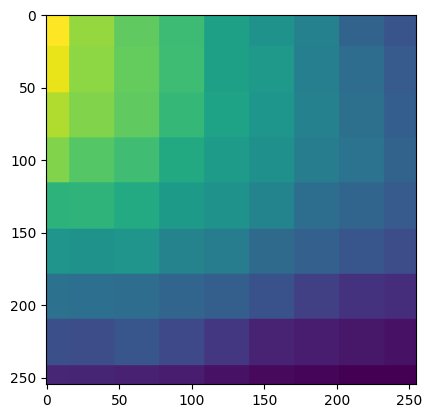

In [142]:
im_v = nl.__getattribute__('float_list').value
im_v = np.array(im_v)
im_v = np.reshape(im_v, (255, 255))
plt.imshow(im_v)

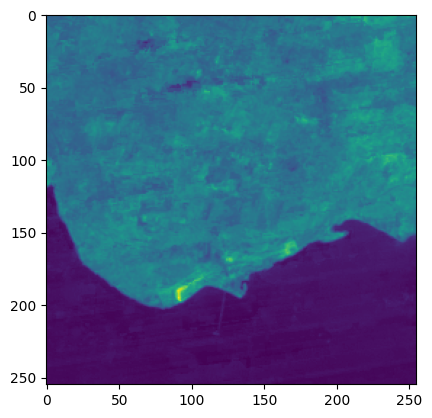

In [130]:
im_v = nir.__getattribute__('float_list').value
im_v = np.array(im_v)
im_v = np.reshape(im_v, (255, 255))
plt.imshow(im_v)

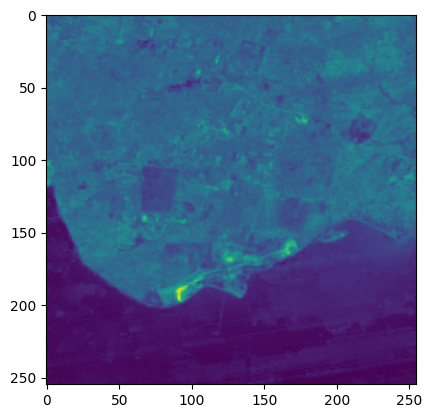

In [129]:
im_v = red.__getattribute__('float_list').value
im_v = np.array(im_v)
im_v = np.reshape(im_v, (255, 255))
plt.imshow(im_v)

In [102]:
REQUIRED_BANDS

['BLUE',
 'GREEN',
 'LAT',
 'LON',
 'NIGHTLIGHTS',
 'NIR',
 'RED',
 'SWIR1',
 'SWIR2',
 'TEMP1']

In [147]:
def print_images(path):
    options = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP)
    iterator = tf.io.tf_record_iterator(path, options=options)
    for record_str in iterator:
        ex = tf.train.Example.FromString(record_str)
        feature_map = ex.features.feature
        fig, axs = plt.subplots(8, 1, figsize=(50,20))
        i=0
        for band in REQUIRED_BANDS:
            if band == 'LAT' or band == 'LON':
                continue
            im = feature_map[band]
            im_v = im.__getattribute__('float_list').value
            im_v = np.array(im_v)
            im_v = np.reshape(im_v, (255, 255))
            # print(im_v)
            axs[i].imshow(im_v)
            axs[i].set_title(band)
            i+=1

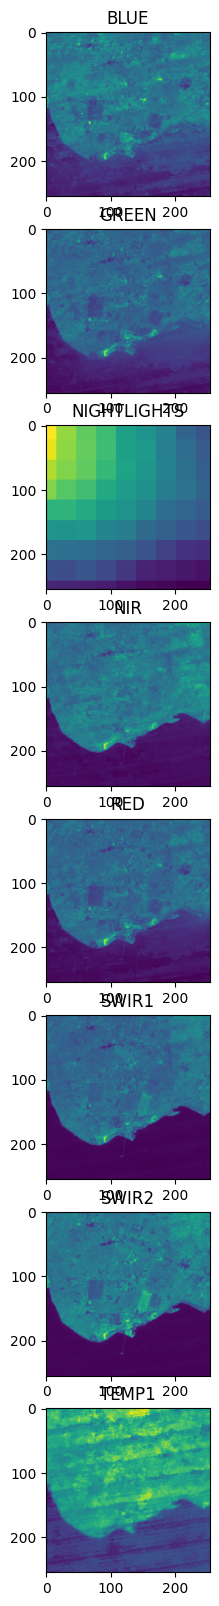

In [148]:
print_images(_)

## Verify the Individual TFRecord Files (Optional)

Check that the label, location, and year values in each individual TFRecord file match the original CSV.

In [67]:
def validate_individual_tfrecords(tfrecord_paths: Iterable[str],
                                  csv_path: str,
                                  label_name: Optional[str] = None) -> None:
    '''
    Args
    - tfrecord_paths: list of str, paths to individual TFRecord files
        in the same order as in the CSV
    - csv_path: str, path to CSV file with columns ['lat', 'lon', 'wealthpooled', 'year']
    '''
    df = pd.read_csv(csv_path, float_precision='high', index_col=False)
    iter_init, batch_op = batcher.Batcher(
        tfrecord_files=tfrecord_paths,
        label_name=label_name,
        ls_bands=None,
        nl_band=None,
        batch_size=128,
        shuffle=False,
        augment=False,
        clipneg=False,
        normalize=None).get_batch()

    locs, years = [], []
    if label_name is not None:
        labels = []

    num_processed = 0
    with tf.Session() as sess:
        sess.run(iter_init)
        while True:
            try:
                if label_name is not None:
                    batch_np = sess.run((batch_op['locs'], batch_op['years'], batch_op['labels']))
                    labels.append(batch_np[2])
                else:
                    batch_np = sess.run((batch_op['locs'], batch_op['years']))
                locs.append(batch_np[0])
                years.append(batch_np[1])
                num_processed += len(batch_np[0])
                print(f'\rProcessed {num_processed} images', end='')
            except tf.errors.OutOfRangeError:
                break
    print()

    locs = np.concatenate(locs)
    years = np.concatenate(years)
    assert (locs == df[['lat', 'lon']].to_numpy(dtype=np.float32)).all()
    assert (years == df['year'].to_numpy(dtype=np.float32)).all()
    if label_name is not None:
        labels = np.concatenate(labels)
        assert (labels == df['wealthpooled'].to_numpy(dtype=np.float32)).all()

In [ ]:
validate_individual_tfrecords(
    tfrecord_paths=tfrecord_paths_utils.dhs(),
    csv_path='data/dhs_clusters.csv',
    label_name='wealthpooled')

In [ ]:
validate_individual_tfrecords(
    tfrecord_paths=tfrecord_paths_utils.dhsnl(),
    csv_path='data/dhsnl_locs.csv')

In [ ]:
validate_individual_tfrecords(
    tfrecord_paths=tfrecord_paths_utils.lsms(),
    csv_path='data/lsms_clusters.csv')

## Calculate Mean and Std-Dev for Each Band

The means and standard deviations calculated here are saved as constants in `batchers/dataset_constants.py` for `_MEANS_DHS`, `_STD_DEVS_DHS`, `_MEANS_LSMS`, and `_STD_DEVS_LSMS`.

In [ ]:
def calculate_mean_std(tfrecord_paths):
    '''Calculates and prints the per-band means and std-devs'''
    iter_init, batch_op = batcher.Batcher(
        tfrecord_files=tfrecord_paths,
        label_name=None,
        ls_bands='ms',
        nl_band='merge',
        batch_size=128,
        shuffle=False,
        augment=False,
        clipneg=False,
        normalize=None).get_batch()

    stats = analyze_tfrecord_batch(
        iter_init, batch_op, total_num_images=len(tfrecord_paths),
        nbands=len(BANDS_ORDER), k=10)
    means, stds = per_band_mean_std(stats=stats, band_order=BANDS_ORDER)

    print('Means:')
    pprint(means)
    print()

    print('Std Devs:')
    pprint(stds)

    print('\n========== Additional Per-band Statistics ==========\n')
    print_analysis_results(stats, BANDS_ORDER)

In [ ]:
calculate_mean_std(tfrecord_paths_utils.dhs())

In [ ]:
calculate_mean_std(tfrecord_paths_utils.dhsnl())

In [ ]:
calculate_mean_std(tfrecord_paths_utils.lsms())